In [1]:
%cd /home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability

/home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability


# Imports

In [2]:
import os
from tqdm.notebook import tqdm

# Analysis
import numpy as np
import xarray as xr 
import pandas as pd

import xeofs # https://github.com/xarray-contrib/xeofs
import xesmf as xe # https://xesmf.readthedocs.io/en/stable/
from xarrayutils import  xr_linregress # https://github.com/jbusecke/xarrayutils
import lenapy # https://github.com/CNES/lenapy
from sklearn.cross_decomposition import PLSRegression

 
# Plotting
import matplotlib.pyplot as plt
plt.style.use('./robin.mplstyle')
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeat
# Change font of plots
from matplotlib.font_manager import fontManager
fontManager.addfont('./Arial.ttf')
fontManager.addfont('./Arial-bold.ttf')
plt.rcParams['font.sans-serif'] = 'Arial'






In [3]:
def get_eof(data, n_modes=3):
    model = xeofs.models.EOF(n_modes=n_modes, use_coslat=True)
    model.fit(data, dim='time')
    components = model.components().persist()
    variance_explained = model.explained_variance_ratio().persist()*100
    timeseries = model.fit_transform(data, dim='time', normalized=False).persist()
    del components.attrs['solver_kwargs']
    del variance_explained.attrs['solver_kwargs']
    return xr.Dataset(dict(components=components, 
                           timeseries=timeseries, 
                           variance_explained=variance_explained))

def get_eof_gf(data, gf, n_modes=3):
    eof = get_eof(data*gf, n_modes=n_modes)
    eof['components_sst'] = eof.components/gf
    eof['pe'] = (eof.components*eof.timeseries).sum(['lon','lat'])
    eof['pe_total'] = (data*gf).sum(['lon','lat'])
    eof['variance_explained_pe'] = eof.pe.var('time')/eof.pe_total.var('time')*100
    return eof


In [4]:
from dask.distributed import Client 
client = Client(n_workers=8)
client

2025-06-26 11:13:49,113 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1926/worker-07kwxeye', purging
2025-06-26 11:13:49,113 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1926/worker-73lw525h', purging
2025-06-26 11:13:49,113 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1926/worker-en26hjbw', purging
2025-06-26 11:13:49,113 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1926/worker-aohe0guq', purging
2025-06-26 11:13:49,114 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1926/worker-bvn439lu', purging
2025-06-26 11:13:49,114 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space-1926/worker-pbnpzxvc', purging
2025-06-26 11:13:49,114 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-s

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33683,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:32975,Total threads: 4
Dashboard: http://127.0.0.1:39149/status,Memory: 7.50 GiB
Nanny: tcp://127.0.0.1:36805,


# Preprocessing
Before this analysis, both SST data and Green's Functions are regridded to a T42 grid. 
SST are regridded using bilinear interpolation and GF are regridded using a conservative regridding using `xesmf`.
For this notebook, regridded SST are stored in `REGRIDDED_SST_DATA_DIR`, the regridded GF are stored in a single netcdf file in `REGRIDDED_GF_PATH` and the ocean basin mask is in `OCEAN_MASK_PATH`.

In [5]:
"""
# Example of regridding using xesmf:

PATH_TO_RAW_SST = '/fill/in/path/here'
PATH_TO_RAW_GF = '/fill/in/path/here'

raw_SST_file = xr.open_dataset(PATH_TO_RAW_SST)
raw_GF_file = xr.open_dataset(PATH_TO_RAW_GF)

# defining a common grid
out_grid = xr.DataArray(dims=['lon','lat'],
                        coords=dict(lon=np.arange(0,360,2.8125), lat=np.linspace(87.8638,-87.8638,64)))

regridded_SST = xe.Regridder(raw_SST_file, out_grid, 'bilinear')(raw_SST_file, keep_attrs=True)
regridded_GF = xe.Regridder(raw_GF_file, out_grid, 'conservative')(raw_GF_file, keep_attrs=True)
"""

"\n# Example of regridding using xesmf:\n\nPATH_TO_RAW_SST = '/fill/in/path/here'\nPATH_TO_RAW_GF = '/fill/in/path/here'\n\nraw_SST_file = xr.open_dataset(PATH_TO_RAW_SST)\nraw_GF_file = xr.open_dataset(PATH_TO_RAW_GF)\n\n# defining a common grid\nout_grid = xr.DataArray(dims=['lon','lat'],\n                        coords=dict(lon=np.arange(0,360,2.8125), lat=np.linspace(87.8638,-87.8638,64)))\n\nregridded_SST = xe.Regridder(raw_SST_file, out_grid, 'bilinear')(raw_SST_file, keep_attrs=True)\nregridded_GF = xe.Regridder(raw_GF_file, out_grid, 'conservative')(raw_GF_file, keep_attrs=True)\n"

# Processing

## Load data: SSTA and GF

In [6]:
# Change dirs to match where the data are.

REGRIDDED_SST_DATA_DIR = '/scratchx/rguillaume/data/tos_hist_damip/obs/'
REGRIDDED_GF_PATH = '/homedata/rguillaume/data/Publications/2024_Guillaume-Castel_historicalPE/data_v7_200624/GREENS_FUNCTIONS_coarse_grid.nc'
OCEAN_MASK_PATH = '/home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability/RECCAP2_region_masks_all_v20221025.nc'

GF = xr.open_dataset(REGRIDDED_GF_PATH).GF_normed
ds_mask = xr.open_dataset(OCEAN_MASK_PATH).open_ocean
mask = ds_mask.interp_like(GF, method='nearest')


SST_files = os.listdir(REGRIDDED_SST_DATA_DIR)
SST_files
all_ds = []
for file in SST_files:
    SST_product = file.split('_')[0]
    if 'AMIP' in SST_product:
        continue
    ds = xr.open_dataset(f'{REGRIDDED_SST_DATA_DIR}/{file}', chunks = dict(lon=32, lat=32)).tos.assign_coords(product=SST_product)
    new_time = pd.date_range(f"{ds.time.dt.year.values[0]}-{ds.time.dt.month.values[0]}",
                                               freq='MS', periods=ds.time.size)
    ds = ds.assign_coords(time=new_time)
    all_ds.append(ds)
ds_tos = xr.concat(all_ds, dim='product')
# We use a common period of 1870 to 2024

# Remove climatology and make anomalies
ds_tos_clim = ds_tos.sel(time=slice('1870','2024')).lntime.climato().load()
ds_tos_clim_ref = ds_tos_clim.sel(time=slice('1870', '1900')).mean('time')
ds_tos_anom = ds_tos_clim - ds_tos_clim_ref
ds_tos_anom_mean = ds_tos_anom.weighted(np.cos(np.deg2rad(ds_tos_anom.lat))).mean(['lon','lat'])
SSTA = ds_tos_anom - ds_tos_anom_mean
SSTA_pac = SSTA.where(mask==2, drop=True)


/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


In [7]:
ds_trop = ds_tos_clim.sel(lat=slice(30,-30)).load()
ranks_trop = ds_trop.stack(space=['lon','lat']).rank('space', pct=True).unstack().T
sst_hash = ds_trop.where(ranks_trop>.7).weighted(np.cos(np.deg2rad(ds_trop.lat))).mean(['lon','lat']) - ds_trop.weighted(np.cos(np.deg2rad(ds_trop.lat))).mean(['lon','lat'])


## Compute Rp

In [8]:
Rp_total = (SSTA*GF).sum(['lon','lat'])
Rp_pac = (SSTA_pac*GF).sum(['lon','lat'])

In [9]:
print((xr_linregress(Rp_pac, Rp_total).r_value**2).mean().values)
print((xr_linregress(Rp_pac, Rp_total).slope).mean().values)

0.8237479513694527
1.089494699181751


In [10]:
# Rp_total.to_netcdf('/homedata/rguillaume/data/Publications/2024_Guillaume-Castel_historicalPE/data_v8/dRp_obs_monthly_1870-2024.nc')

## Compute EOFs

In [12]:
all_eofs = []
for product in tqdm(SSTA_pac.product):
    all_eofs_product = []
    for GF_source in tqdm(GF.GF_source):
        eof_pac_gf = get_eof_gf(SSTA_pac.sel(product=product), GF.sel(GF_source=GF_source),n_modes=20).assign_coords(GF_source=GF_source)
        all_eofs_product.append(eof_pac_gf)
    eofs_pac_product = xr.concat(all_eofs_product, dim='GF_source').assign_coords(product=product)
    eofs_pac_product = eofs_pac_product.rename(dict(components="components",
                                    timeseries="timeseries",
                                    variance_explained="variance_explained",
                                    components_sst="components_sst",
                                    pe="pe",
                                    pe_total="pe_total_eofs_pac",
                                    variance_explained_pe="variance_explained_pe_eofs_pac",))
    all_eofs.append(eofs_pac_product)
all_eofs_pac = xr.concat(all_eofs, dim='product')



# Normalize all patters b sign and apmlitude
sign_eof = np.sign(all_eofs_pac.components_sst.sel(lon=200, lat=0, method='nearest'))
sign_eof.loc[dict(mode=2)] = -np.sign(all_eofs_pac.components_sst.sel(mode=2).where(all_eofs_pac.lat>50).mean(['lon','lat']))
sign_eof.loc[dict(mode=2, product='ERSSTv5')] = np.sign(all_eofs_pac.components_sst.sel(mode=2, product='ERSSTv5', lon =slice(245,250), lat=slice(-5,5)).mean(['lon','lat']))
sign_eofs =sign_eof#*(all_eofs_pac.timeseries.std('time')
lbd_timeseries = all_eofs_pac.timeseries.std('time')
lbd_pattern = all_eofs_pac.components_sst.weighted(np.cos(np.deg2rad(all_eofs_pac.lat))).std(['lon','lat'])

amplitude_eofs = sign_eof/all_eofs_pac.components_sst.std(['lon','lat'])
all_eofs_pac['timeseries'] = all_eofs_pac['timeseries']*sign_eof/lbd_timeseries
all_eofs_pac[['components_sst','components']] =all_eofs_pac[['components_sst','components']]*sign_eof/lbd_pattern
all_eofs_pac['lambdas'] = lbd_pattern*lbd_timeseries
all_eofs_pac['pi'] = (all_eofs_pac.components_sst*GF).sum(['lon','lat'])
all_eofs_pac = all_eofs_pac.rename(mode='feature')

all_eofs_pac[['components','components_sst','pi']] = all_eofs_pac[['components','components_sst','pi']]*np.sign(all_eofs_pac.pi)

eofs_pac = all_eofs_pac.isel(feature=np.arange(3))

eofs_pac['lambdas_scaled'] = eofs_pac.lambdas/Rp_pac.std('time')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Compute PLSR

In [13]:
all_output = []
for product in SSTA_pac.product.values:
    pattern = SSTA_pac.sel(product=product, drop=True)
    all_product = []
    for gf_choice in tqdm(GF.GF_source):
        GF_mean = GF.sel(GF_source=gf_choice, drop=True)
        X = pattern#*GF_mean
        Y = Rp_pac.sel(GF_source=gf_choice, product=product)
        X = X.sel(time=Y.time)

        weights_X = xr.ones_like(X)*np.cos(np.deg2rad(GF.lat))
        X = X.stack(space=['lon','lat'])
        weights_X = weights_X.stack(space=['lon','lat'])
        X = X.dropna('space')
        weights_X = weights_X.sel(space=X.space)
        
        n_components = 20
        pls2 = PLSRegression(n_components=n_components, scale=False)
        pls2.fit(X*weights_X, Y)

        components =  xr.DataArray(pls2.x_loadings_[:]/weights_X.isel(time=range(n_components), drop=True).T, dims=['space','mode'], coords=dict(space=X.space)).unstack().sortby(['lon','lat']).transpose('mode','lat','lon')        
        timeseries =  xr.DataArray(pls2.x_scores_, dims=['time','mode'], coords=dict(time=X.time))
        components_sst = components#/GF_mean
        components = components_sst*GF_mean
        ds_out_one = xr.Dataset(dict(components_sst=components_sst,
                                     components=components,
                                     timeseries=timeseries)).assign_coords(product=product, GF_source=gf_choice)
        ds_out_one['pe'] = (ds_out_one.components.sum(['lon','lat'])*ds_out_one.timeseries)
        all_product.append(ds_out_one)
        # plt.figure()
        # ds_out_one.pe.to_series().plot.barh
    ds_product = xr.concat(all_product, dim='GF_source').assign_coords(mode=np.arange(1,21))
    all_output.append(ds_product)
all_plsr_pac = xr.concat(all_output, dim='product')


# Normalize all patters b sign and apmlitude
sign_plsr = np.sign(all_plsr_pac.components_sst.sel(lon=200, lat=0, method='nearest'))
sign_plsr.loc[dict(mode=3)] = -np.sign(all_plsr_pac.components_sst.sel(mode=3).where(all_plsr_pac.lat>50).mean(['lon','lat']))

lbd_timeseries = all_plsr_pac.timeseries.std('time')
lbd_pattern = all_plsr_pac.components_sst.weighted(np.cos(np.deg2rad(all_plsr_pac.lat))).std(['lon','lat'])

all_plsr_pac['timeseries'] = all_plsr_pac['timeseries']*sign_plsr/lbd_timeseries
all_plsr_pac[['components_sst','components']] =all_plsr_pac[['components_sst','components']]*sign_plsr/lbd_pattern
all_plsr_pac['lambdas'] = lbd_pattern*lbd_timeseries
all_plsr_pac['pi'] = (all_plsr_pac.components_sst*GF).sum(['lon','lat'])
all_plsr_pac = all_plsr_pac.rename(mode='feature')
all_plsr_pac[['components','components_sst','pi']] = all_plsr_pac[['components','components_sst','pi']]*np.sign(all_plsr_pac.pi)

plsr_pac = all_plsr_pac.isel(feature=np.arange(3))


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Compute ENSO indices


In [14]:

# EP CP ENSO from https://icar.nuist.edu.cn/en/NlNinoIndices/listm.psp
nino34_bounds = {"lat": slice(5, -5), "lon": slice(190, 240)}  # 160°E to 150°W
nino3_bounds = {"lat": slice(5, -5), "lon": slice(210, 270)}  # 150°W to 90°W
nino4_bounds = {"lat": slice(5, -5), "lon": slice(160, 210)}  # 160°E to 150°W

nino34 = SSTA.sel(nino34_bounds).weighted(np.cos(np.deg2rad(SSTA.lat))).mean(['lon','lat']) 
nino3 = SSTA.sel(nino3_bounds).weighted(np.cos(np.deg2rad(SSTA.lat))).mean(['lon','lat'])
nino4 = SSTA.sel(nino4_bounds).weighted(np.cos(np.deg2rad(SSTA.lat))).mean(['lon','lat'])
alpha = xr.ones_like(nino3).where(nino3*nino4>0,0)*2/5

EP = nino3 - alpha*nino4
CP = nino4 - alpha*nino3


modes = xr.concat([nino34.assign_coords(mode='nino34'),
                   CP.assign_coords(mode='CP'),
                   EP.assign_coords(mode='EP'),
                   ], dim='mode')

regr_modes = xr_linregress(modes, SSTA.where(mask==2, drop=True), dim='time')
regr_modes['mode_timeseries'] = modes 
modes_obs = regr_modes.rename(slope='mode_pattern')[['mode_timeseries', 'mode_pattern']]

modes_obs['lambdas'] = modes_obs.mode_pattern.weighted(np.cos(np.deg2rad(modes_obs.lat))).std(['lon','lat'])
modes_obs['mode_pattern'] = modes_obs.mode_pattern/modes_obs.lambdas
modes_obs['pi'] = (modes_obs.mode_pattern*GF).sum(['lon','lat'])

# Main Figures

## Figure 1: maps of modes

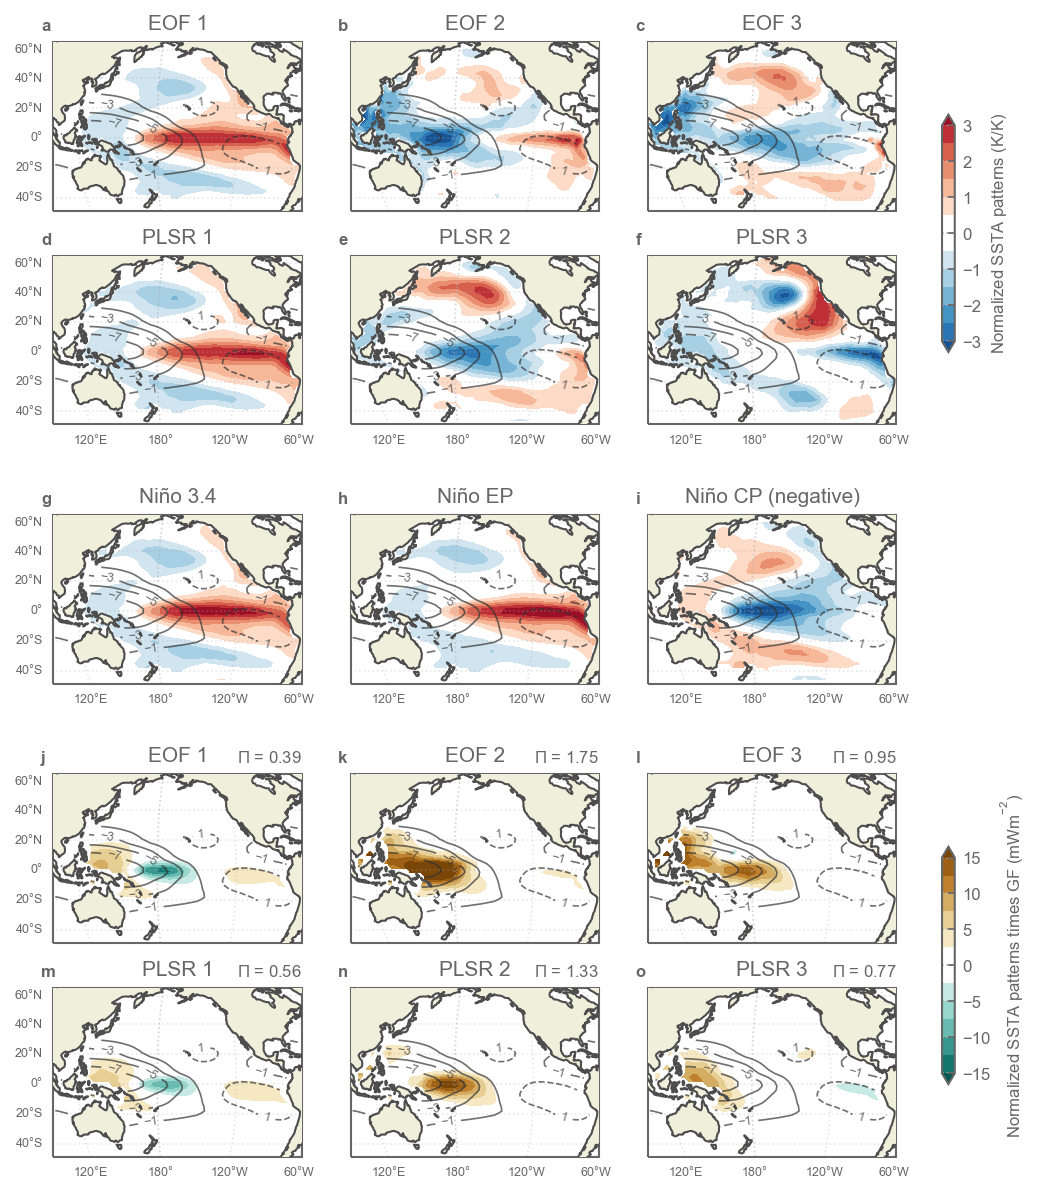

In [15]:
mean_eofs = eofs_pac.mean(['GF_source','product'])
mean_plsr = plsr_pac.mean(['GF_source','product'])

fig, axs = plt.subplot_mosaic("""
                              ABCy
                              DEFy
                              ....
                              MNO.
                              ....
                              GHIx
                              JKLx
                              """,
                              figsize=(7,8),
                              width_ratios=[20,20,20,1],
                              height_ratios=[10,10,0,10,0,10,10],
                              per_subplot_kw=dict(ABCDEFGHIJKLMNO=dict(projection=ccrs.Robinson(200))))
palette_sst=sns.color_palette('RdBu_r',n_colors=14)
palette_sst[6] = (1,1,1)
palette_sst[7] = (1,1,1)
palette_gf=sns.color_palette('BrBG_r',n_colors=14)
palette_gf[6] = (1,1,1)
palette_gf[7] = (1,1,1)
palette_gf

axs_sst_eof = ['A','B','C']
axs_sst_plsr = ['D','E','F']
axs_modes = ['M','N','O']
axs_gf_eof = ['G','H','I']
axs_gf_plsr = ['J','K','L']
all_axs= axs_sst_eof+axs_sst_plsr+axs_modes+axs_gf_eof+axs_gf_plsr

levels_gf = np.arange(-15,15.1, 2.5)
levels_sst = np.arange(-3,3.1,.5) 


mean_eofs = eofs_pac.mean(['GF_source','product'])
mean_plsr = plsr_pac.mean(['GF_source','product'])
mean_gf = GF.sel(GF_source='mean', lon=mean_eofs.lon, lat=mean_eofs.lat)

mean_eofs['components_sst'] = (mean_eofs['components_sst']/mean_eofs['components_sst'].weighted(np.cos(np.deg2rad(mean_eofs.lat))).std(['lon','lat']))
mean_eofs['components'] = mean_eofs.components_sst*mean_gf
mean_plsr['components_sst'] = (mean_plsr['components_sst']/mean_plsr['components_sst'].weighted(np.cos(np.deg2rad(mean_plsr.lat))).std(['lon','lat']))
mean_plsr['components'] = mean_plsr.components_sst*mean_gf


for k in range(3):
    
    (1000*mean_eofs.components).sel(feature=k+1).plot.contourf(ax=axs[axs_gf_eof[k]], transform=ccrs.PlateCarree(), levels=levels_gf, cbar_ax=axs['x'], extend='both', colors=palette_gf)
    (1000*mean_plsr.components).sel(feature=k+1).plot.contourf(ax=axs[axs_gf_plsr[k]], transform=ccrs.PlateCarree(), levels=levels_gf, cbar_ax=axs['x'], extend='both', colors=palette_gf)
    (mean_eofs.components_sst.sel(feature=k+1)).plot.contourf(ax=axs[axs_sst_eof[k]], transform=ccrs.PlateCarree(), levels=levels_sst, cbar_ax=axs['y'], extend='both', colors=palette_sst)
    (mean_plsr.components_sst.sel(feature=k+1)).plot.contourf(ax=axs[axs_sst_plsr[k]], transform=ccrs.PlateCarree(), levels=levels_sst, cbar_ax=axs['y'], extend='both', colors=palette_sst)


modes_pattern_mean = modes_obs.mode_pattern.mean('product')
modes_pattern_mean = modes_pattern_mean/modes_pattern_mean.weighted(np.cos(np.deg2rad(mean_plsr.lat))).std(['lon','lat'])

modes_pattern_mean.sel(mode='nino34').plot.contourf(ax=axs['M'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)
modes_pattern_mean.sel(mode='EP').plot.contourf(ax=axs['N'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)
(-modes_pattern_mean.sel(mode='CP')).plot.contourf(ax=axs['O'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)

axs['x'].set_yticks(np.arange(-15,15.1, 5))
axs['y'].set_yticks(np.arange(-3,3.1,1))
axs['x'].minorticks_off()
axs['y'].minorticks_off()
axs['x'].set_ylabel(r'Normalized $SSTA$ patterns times $GF$ (mWm$^{-2}$)')
axs['y'].set_ylabel(r'Normalized $SSTA$ patterns (K/K)')

for k,letter in enumerate(all_axs):
    ax=axs[letter]
    ax.add_feature(cfeat.LAND, edgecolor='.3', zorder=100)
    ax.set_title('')
    c = (mean_gf.sel(lon=mean_eofs.lon, lat=mean_eofs.lat)*1000).plot.contour(levels=[-7,-5,-3,-1,1], extend='both', ax=ax, 
                                                                          zorder=1000, colors='.2', transform=ccrs.PlateCarree(),
                                                                          linewidths=.8, linestyles=['-','-','-','-','--'], alpha=.7)
    ax.clabel(c, c.levels, fmt=None, fontsize=6)
    gl = ax.gridlines(draw_labels=True, alpha=.3)
    if letter not in axs_gf_plsr+axs_sst_plsr+axs_modes:
        gl.bottom_labels=False
    if True:
        gl.top_labels=False
    if letter not in ['A','D','M','G','J']:
        gl.left_labels=False
    gl.ylabel_style=dict(size=6)
    gl.xlabel_style=dict(size=6)
    label = chr(ord('a')+k)
    ax.text(-.05,1.05, label, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.set_ylabel('')

    
for k, letter in enumerate(axs_gf_eof):
    ax=axs[letter]
    ax.text(1,1.05, r"$\Pi$"+f" = {mean_eofs.pi.isel(feature=k).values:.02f}", weight='normal', ha='right', va='bottom', transform=ax.transAxes)
for k, letter in enumerate(axs_gf_plsr):
    ax=axs[letter]
    ax.text(1,1.05, r"$\Pi$"+f" = {mean_plsr.pi.isel(feature=k).values:.02f}", weight='normal', ha='right', va='bottom', transform=ax.transAxes)

for k,letters in enumerate(zip(axs_sst_eof,axs_sst_plsr,axs_gf_eof,axs_gf_plsr)):
    a,b,c,d = letters
    axs[a].set_title(f'EOF {k+1}')
    axs[b].set_title(f'PLSR {k+1}')
    axs[c].set_title(f'EOF {k+1}')
    axs[d].set_title(f'PLSR {k+1}')


axs['M'].set_title('Niño 3.4')
axs['N'].set_title('Niño EP')
axs['O'].set_title('Niño CP (negative)')
plt.tight_layout()


plt.savefig('plots/maps_features_with_modes.pdf', dpi=300)


## Figure 2: Comparison with ENSO

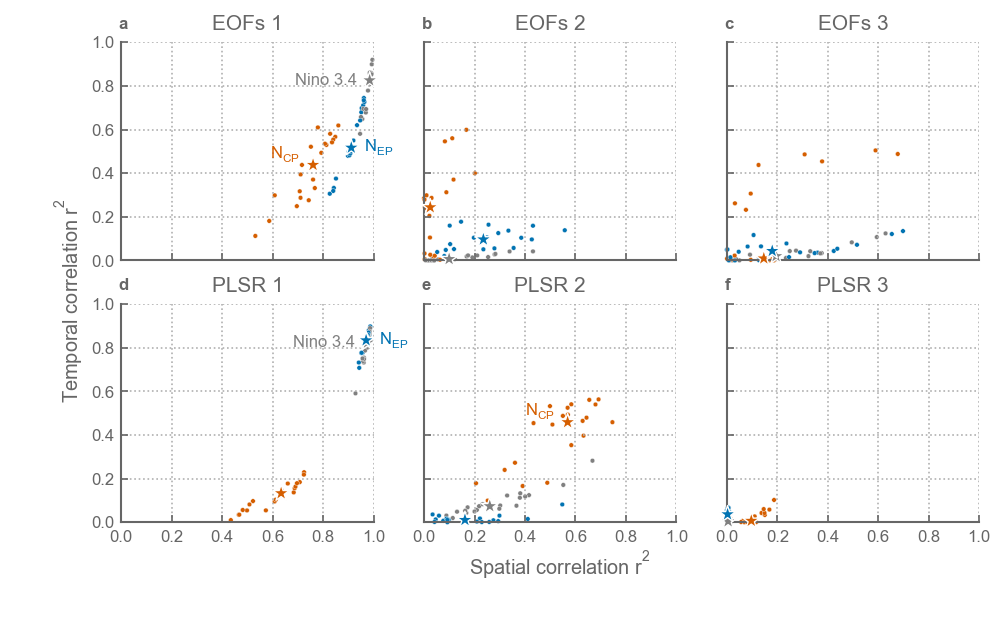

In [16]:
ds_features = xr.concat([eofs_pac.assign_coords(method='EOFs'), plsr_pac.assign_coords(method='PLSR')], dim='method')
temp_regr = xr_linregress(modes,ds_features.timeseries)
space_regr1 = xr_linregress(regr_modes.slope,ds_features.components_sst, dim=['lon','lat']).r_value
space_regr = xr.corr(regr_modes.slope,ds_features.components_sst, dim=['lon','lat'], weights = np.cos(np.deg2rad(regr_modes.lat)))

regr_both = xr.Dataset(dict(regr_space=space_regr,regr_time=temp_regr.r_value))
df_regr_mean = ((regr_both).mean(['GF_source','product']).to_dataframe()).reset_index()
df_regr_mean['feature'] = 'Feature '+df_regr_mean['feature'].astype(str) 

df_regr_all = ((regr_both).to_dataframe()).reset_index()
df_regr_all['feature'] = 'Feature '+df_regr_all['feature'].astype(str) 

fig, axs = plt.subplots(2,3, figsize=(6.5, 4), sharex=True, sharey=True)

for k, ax in enumerate(axs.flatten()):
    feature = k%3
    method = k//3
    regr_plot = regr_both.sel(mode=['nino34','CP','EP', ]).isel(method=method, feature=feature)**2
    df_ = regr_plot.to_dataframe().reset_index()
    df_mean = regr_plot.median(['GF_source', 'product']).to_dataframe().reset_index()
    sns.scatterplot(df_,x='regr_space',y='regr_time', ax=ax, hue='mode', s=5, legend=False, alpha=1,edgecolor='1', clip_on=False, palette=['.5','C3', 'C0'])
    sns.scatterplot(df_mean,x='regr_space',y='regr_time', ax=ax, hue='mode', s=70, zorder=100, clip_on=False, marker='*', edgecolor='1', palette=['.5','C3', 'C0'])
    ax.set(xlim=(0,1), ylim=(0,1))
    ax.set(xlabel='', ylabel='')
    ax.set_title(f"{regr_plot.method.values} {feature+1}")
    ax.legend().remove()
    if k in [0,3]:
        ax.text(df_mean.iloc[0].regr_space-.05, df_mean.iloc[0].regr_time, 'Nino 3.4', color='.5', ha='right', va='center',)
        ax.text(df_mean.iloc[2].regr_space+.05, df_mean.iloc[2].regr_time, 'N$_{EP}$', color='C0', ha='left', va='center',)
    if k in [0,4]:
        ax.text(df_mean.iloc[1].regr_space-.05, df_mean.iloc[1].regr_time+0.05, 'N$_{CP}$', color='C3', ha='right', va='center',)
    ax.text(-.01, 1.05, chr(ord('a')+k), transform=ax.transAxes, ha='left', va='bottom', weight='bold')
    
fig.supxlabel('Spatial correlation r$^2$',y=0.03, x=.55)
fig.supylabel('Temporal correlation r$^2$', x=0.03, ha='left')

plt.subplots_adjust(left=.1, bottom=.13, right=0.98, top=.93)

plt.savefig('plots/Correlation_features_with_modes.pdf')

In [319]:
df_regr_mean.sort_values('method').set_index(['method','feature','mode']).sort_index()**2

regr_space  regr_time
method feature   mode                         
EOFs   Feature 1 CP        0.744681   0.404231
                 EP        0.912235   0.535005
                 nino34    0.978234   0.788343
       Feature 2 CP        0.021164   0.170616
                 EP        0.020381   0.079267
                 nino34    0.005612   0.007465
       Feature 3 CP        0.149713   0.065631
                 EP        0.089992   0.001627
                 nino34    0.119760   0.020406
PLSR   Feature 1 CP        0.598802   0.108174
                 EP        0.969080   0.826110
                 nino34    0.971983   0.806854
       Feature 2 CP        0.511708   0.384930
                 EP        0.159135   0.000066
                 nino34    0.271122   0.082108
       Feature 3 CP        0.090994   0.010794
                 EP        0.001213   0.024220
                 nino34    0.004983   0.002522

## Figure 3: Contribution to Pattern Effect

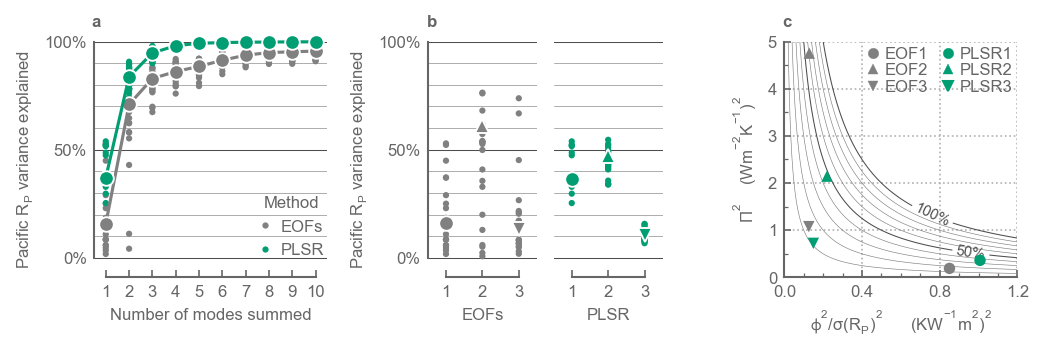

In [17]:

fig, axs = plt.subplot_mosaic("""
                              ABCD
                              """, figsize=(7,2.4), 
                              gridspec_kw=dict(width_ratios=[3,1,1,3])
                              )

df_1 = eofs_pac[['pi','lambdas']].to_dataframe()
df_1['dRp_var'] = Rp_pac.var('time').to_series()
df_1['method']='EOFs'

df_2 = plsr_pac[['pi','lambdas']].to_dataframe()
df_2['dRp_var'] = Rp_pac.var('time').to_series()
df_2['method']='PLSR'

df = pd.concat([df_1,df_2])

df['lambdas_scaled'] = df.lambdas/np.sqrt(df.dRp_var)
df['lambdas_scaled_squared'] = df.lambdas**2/df.dRp_var
df['lambdas_squared'] = df.lambdas**2
df['pi_squared'] = df.pi**2
df['sigmaRp'] = np.sqrt(df.dRp_var)
df['abs_pi'] = np.abs(df.pi)
df['var_explained'] = 100*df.pi_squared*df.lambdas_squared/df.dRp_var
df['x_value'] = df.lambdas**2/df.dRp_var
df['y_value'] = df.abs_pi**2

df_mean = df.groupby(['feature','method']).mean(numeric_only=True)
df_mean['var_explained'] = 100*(df_mean.pi_squared*df_mean.lambdas_squared/df_mean.dRp_var)
df_mean['x_value'] = df_mean.lambdas_squared/df_mean.dRp_var
df_mean['y_value'] = df_mean.pi_squared


#### First panel

var_cum_eof = all_eofs_pac.pe.cumsum('feature').var('time')
var_cum_plsr = all_plsr_pac.pe.cumsum('feature').var('time')
var_cum_ratio_eof = 100*var_cum_eof/Rp_pac.var('time')
var_cum_ratio_plsr = 100*var_cum_plsr/Rp_pac.var('time')

var_cum_ratio_mean_eof = 100*var_cum_eof.mean(['product','GF_source'])/Rp_pac.var('time').mean(['product','GF_source'])
var_cum_ratio_mean_plsr = 100*var_cum_plsr.mean(['product','GF_source'])/Rp_pac.var('time').mean(['product','GF_source'])

df_cum_1 = var_cum_ratio_eof.rename('var_ratio').to_series().reset_index()
df_cum_2 = var_cum_ratio_plsr.rename('var_ratio').to_series().reset_index()
df_cum_1['method'] = 'EOFs'
df_cum_2['method'] = 'PLSR'
df_cum = pd.concat([df_cum_1, df_cum_2])

df_cum_mean_1 = var_cum_ratio_mean_eof.rename('var_ratio').to_series().reset_index()
df_cum_mean_2 = var_cum_ratio_mean_plsr.rename('var_ratio').to_series().reset_index()
df_cum_mean_1['method']= 'EOFs'
df_cum_mean_2['method'] = 'plPLSRsr'
df_cum_mean = pd.concat([df_cum_mean_1, df_cum_mean_2])

sns.stripplot(df_cum.query("feature<11"), x='feature',y='var_ratio' , jitter=False, s=3, dodge=False, hue='method', palette=['0.5','C2'],ax=axs['A'])
sns.pointplot(df_cum_mean.query("feature<11"), x='feature',y='var_ratio', dodge=False, hue='method', linewidth=1.5,palette=['0.5','C2'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,ax=axs['A'], legend=False, clip_on=False)

axs['A'].set_ylim(-9,100)
axs['A'].set_xlabel('')
sns.despine(ax=axs['A'], trim=True)
axs['A'].yaxis.set_major_formatter("{x:.0f}%")

axs['A'].yaxis.set_minor_locator(plt.MultipleLocator(10))
axs['A'].yaxis.set_major_locator(plt.MultipleLocator(50))
axs['A'].grid(which='minor', ls='-',color='.5', linewidth=.3, axis='y')
axs['A'].grid(which='major', ls='-',color='.3', linewidth=.5, axis='y')
axs['A'].tick_params(left=False, which='both')
axs['A'].set_ylabel('Pacific '+r'R$_P$'+' variance explained')
axs['A'].legend(title='Method', loc='lower right', bbox_to_anchor=(1.05,0.02))
axs['A'].set_xlabel('Number of modes summed')



############## Second panel


sns.stripplot(df.query("feature<4 & method=='EOFs'"), x='feature',y='var_explained' , jitter=False, s=3, dodge=False, hue='method', palette=['0.5'], legend=False, ax=axs['B'])
sns.pointplot(df_mean.query("feature<4 & method=='EOFs'"), x='feature',y='var_explained', dodge=False, hue='feature',markers=['o','^','v'], palette=['0.5','0.5','0.5'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,linewidth=0, legend=False, ax=axs['B'],)

sns.stripplot(df.query("feature<4 & method=='PLSR'"), x='feature',y='var_explained' , jitter=False, s=3, dodge=False, hue='method', palette=['C2'], legend=False, ax=axs['C'])
sns.pointplot(df_mean.query("feature<4 & method=='PLSR'"), x='feature',y='var_explained', dodge=False, hue='feature',markers=['o','^','v'], palette=['C2','C2','C2'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,linewidth=0, legend=False, ax=axs['C'],)

for ax in [axs['C'],axs['B']]:
    ax.set_ylim(-9,100)
    ax.set_xlabel('')
    sns.despine(ax=ax, trim=True)
    ax.yaxis.set_major_formatter("{x:.0f}%")
    ax.set_xticks([0,1,2])
    ax.set_xlabel('')
    ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.yaxis.set_major_locator(plt.MultipleLocator(50))
    ax.grid(which='minor', ls='-',color='.5', linewidth=.3, axis='y')
    ax.grid(which='major', ls='-',color='.3', linewidth=.5, axis='y')
    ax.tick_params(left=False, which='both')

axs["C"].tick_params(left=False,labelleft=False)
sns.despine(ax=axs["C"], left=True)
axs['C'].set_ylabel('')
axs['C'].set_xlabel('PLSR')
axs['B'].set_xlabel('EOFs')
axs['B'].set_ylabel('Pacific '+r'R$_P$'+' variance explained')


###### Third panel


x_value_text = df_mean.x_value.copy()
x_value_text.loc[x_value_text.index.get_level_values(0)==1] = x_value_text-0.01
df_mean['x_value_text'] = x_value_text

sns.scatterplot(df_mean, x='x_value', y='y_value', hue='method', palette=['0.5','C2'],s=30, zorder=100, legend=False,ax=axs['D'], style='feature', linewidth=0,markers=['o','^','v'], clip_on=False)

pis = xr.DataArray(np.arange(0,5.1,.1), dims=['pi'], coords=dict(pi = np.arange(0,5.1,.1)))
lambdas = xr.DataArray(np.arange(0,1.31,.01), dims=['lambdas'], coords=dict(lambdas = np.arange(0,1.31,.01)))
var_explained_contours = 100*((np.abs(pis)*lambdas))

c1 = var_explained_contours.plot.contour(levels=np.arange(50,101,50),colors='.3', linewidths=.5,ax=axs['D'])
c1_ = var_explained_contours.plot.contour(levels=[10,20,30,40,60,70,80,90],colors='.5', linewidths=.3,ax=axs['D'])

axs['D'].clabel(c1, fmt=lambda x:f"{x:.0f}%", fontsize=7)

plt.tight_layout()

axs['D'].xaxis.set_major_locator(plt.MultipleLocator(0.4))
axs['D'].yaxis.set_major_locator(plt.MultipleLocator(1))
axs['D'].xaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs['D'].yaxis.set_minor_locator(plt.MultipleLocator(.5))

axs['D'].set_ylim(0,5)
sns.despine(ax=axs['D'],)
axs['D'].set_xlim(0,1.2)
axs['D'].set_ylabel('$\Pi^2$    ($Wm^{-2}K^{-1}$)$^2$')
axs['D'].set_xlabel('$\phi^2/\sigma(R_P)^2$      ($KW^{-1}m^{2}$)$^2$')

legend_elements = [Line2D([0], [0], marker='o', color='.5', label='EOF1',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='^', color='.5', label='EOF2',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='v', color='.5', label='EOF3',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='o', color='C2', label='PLSR1',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='^', color='C2', label='PLSR2',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='v', color='C2', label='PLSR3',linewidth=0,
                          markerfacecolor='C2', markersize=5),
                   ]

axs['D'].legend(handles = legend_elements,ncols=2, loc='upper right', bbox_to_anchor=(1,1), borderpad=0, labelspacing=0.1, handletextpad=.3, borderaxespad=.3, columnspacing=.8)
####### Final tweaks 

axs['A'].text(-.01, 1.05,'a', transform=axs['A'].transAxes, ha='left', va='bottom', weight='bold')
axs['B'].text(-.01, 1.05, 'b', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')
axs['D'].text(-.01, 1.05, 'c', transform=axs['D'].transAxes, ha='left', va='bottom', weight='bold')

plt.tight_layout()


pos_B = axs["B"].get_position()
pos_C = axs["C"].get_position()


axs["B"].set_position([pos_B.x0, pos_B.y0, pos_B.width+.03, pos_B.height])
axs["C"].set_position([pos_C.x0-0.05, pos_C.y0, pos_C.width+.03, pos_C.height])

plt.savefig('plots/percent_variance_explained_by_modes_v2.pdf')


In [328]:
df_mean.var_explained

feature  method
1        EOFs      16.233205
         PLSR      36.339957
2        EOFs      61.059407
         PLSR      47.140055
3        EOFs      13.574965
         PLSR      10.787287
Name: var_explained, dtype: float64

## Figure 4: Lag-regressions with CERES

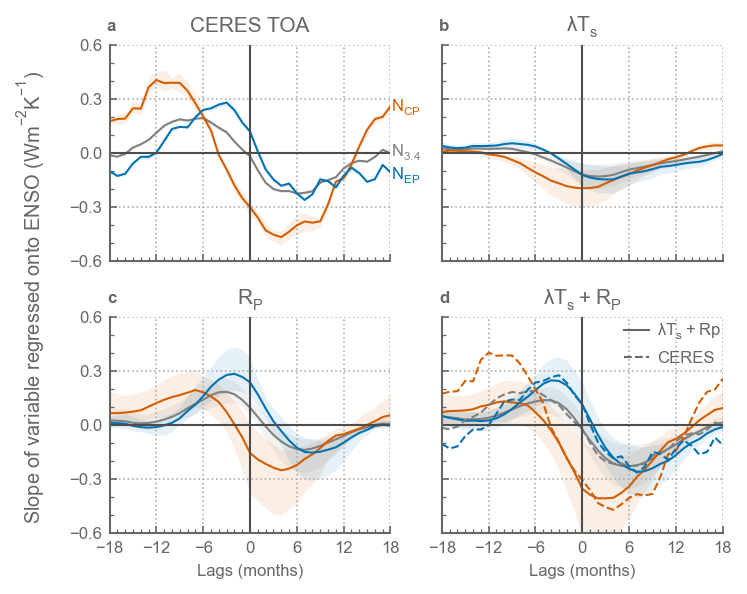

In [37]:
ds_ceres = xr.open_dataset('/projets/EMC2/data/Observations/EEI/CERES/CERES_EBAF-TOA_Ed4.2.1_Subset_200003-202411.nc')
ds_ceres['time'] = pd.date_range(f'{ds_ceres.time.dt.year.values[0]}-{ds_ceres.time.dt.month.values[0]}', freq='MS', periods=ds_ceres.time.size)
ds_ceres = ds_ceres.sel(time=slice('2000-11', '2024-11')).lntime.climato(trend=False).gtoa_net_all_mon

ds_tas = xr.open_dataset('/projets/EMC2/data/Observations/TAS/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.nc').tas_mean
ds_tas['time'] = pd.date_range(f'{ds_tas.time.dt.year.values[0]}-{ds_tas.time.dt.month.values[0]}', freq='MS', periods=ds_tas.time.size)
ds_tas = ds_tas.sel(time=ds_ceres.time).lntime.climato(trend=False)

fig, axs = plt.subplots(2,2,figsize=(5,4), sharex=True, sharey=True)
axs = axs.flatten()

# IPCC estimates for lambda: –1.16 [–1.81 to –0.51] median+90% ci

P95 = -1.81
P5 = -0.51
mu = -1.16

sigma = (P5-P95)/2/1.645
lambda_dist = xr.DataArray(np.random.normal(loc=mu, scale=sigma, size=100), dims=['lbd_sample'], coords=dict(lbd_sample=np.arange(100)))


modes_notrend = (modes_obs.mode_timeseries.sel(time=ds_ceres.time)).lntime.climato(trend=False, mean=False)
ceres_notrend = ds_ceres.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)
lbd_tas_notrend = ds_tas.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)*lambda_dist
Rp_notrend = Rp_total.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)

ds_ceres_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), ceres_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_temp_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), lbd_tas_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_pattern_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), Rp_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_both_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k),lbd_tas_notrend+Rp_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope



(ds_ceres_lag).rename(lag='time').lntime.plot(hue='mode', ax=axs[0], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color=['.5','C3','C0'])



(ds_temp_lag).rename(lag='time').lntime.plot(hue='mode', ax=axs[1], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1,color=['.5','C3','C0'])

(ds_pattern_lag).rename(lag='time').lntime.plot(hue='mode', ax=axs[2], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1,color=['.5','C3','C0'])


(ds_pattern_lag+ds_temp_lag).rename(lag='time').lntime.plot(hue='mode', ax=axs[3], thick_line='mean', shaded_area_alpha=.1,color=['.5','C3','C0'])
(ds_ceres_lag).rename(lag='time').lntime.plot(hue='mode', ax=axs[3], shaded_area=None, thick_line='mean', line_kwargs=dict(ls='--'),color=['.5','C3','C0'])


for k,ax in enumerate(axs):
    ax.axhline(0, color='.3')
    ax.axvline(0, color='.3')
    if k>1:
        ax.set(xlabel='Lags (months)')
    else:
        ax.set(xlabel='')
    ax.xaxis.set_major_locator(plt.MultipleLocator(6))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(.3))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(.1))
    ax.set_ylabel('')
    ax.set_title('')
    ax.set_xlim((-18,18))
    ax.set_ylim((-.6,.6))

axs[1].legend().remove()
axs[2].legend().remove()


axs[0].plot(0,1,label='N$_{3.4}$', color = '.5')
axs[0].plot(0,1,label='N$_{CP}$', color = 'C3')
axs[0].plot(0,1,label='N$_{EP}$', color = 'C0')

leg = axs[0].legend().remove()
# axs[0].legend(handles=leg.legend_handles[3:],bbox_to_anchor=(0.9,1.05), loc='upper right',labelspacing=.2)

axs[0].text(18.1,0,'N$_{3.4}$', ha='left',va='center', color='.5')
axs[0].text(18.1,0.25,'N$_{CP}$', ha='left',va='center', color='C3')
axs[0].text(18.1,-0.13,'N$_{EP}$', ha='left',va='center', color='C0')

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='.4', lw=1,),
                Line2D([0], [0], color='.4', lw=1, ls='--')]

leg = axs[3].legend()
axs[3].legend(custom_lines, ['$\lambda T_s+Rp$','CERES'], handlelength=1.5, bbox_to_anchor=(1.05,1.05), loc='upper right')

fig.supylabel(r'Slope of variable regressed onto ENSO (Wm$^{-2}$K$^{-1}$)')

axs[0].set_title('CERES TOA')
axs[1].set_title(r'$\lambda T_s$')
axs[2].set_title('$R_P$')
axs[3].set_title('$\lambda T_s + R_P$')

for k,ax in enumerate(axs):
    ax.text(-.01, 1.05, chr(ord('a')+k), transform=ax.transAxes, ha='left', va='bottom', weight='bold')


plt.tight_layout()
    

plt.savefig('plots/compare_with_ceres_lag_corr.pdf', dpi=300)


# Supplementary figure

## Figure S1: compare pattern differences

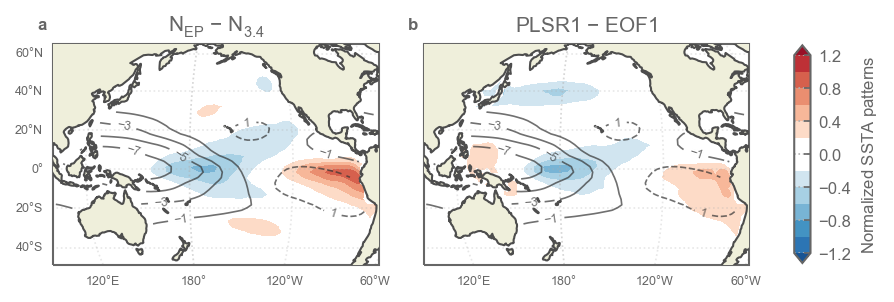

In [38]:

fig, axs = plt.subplot_mosaic("""
                              ABx
                              """,
                              figsize=(6,2),
                              width_ratios=[20,20,1],
                              per_subplot_kw=dict(AB=dict(projection=ccrs.Robinson(200))))

palette_sst=sns.color_palette('RdBu_r',n_colors=14)
palette_sst[6] = (1,1,1)
palette_sst[7] = (1,1,1)



levels_sst = np.arange(-1.2,1.3,.2) 

plsr1 = plsr_pac.components_sst.isel(feature=0).mean(['GF_source','product'])
eof1 = eofs_pac.components_sst.isel(feature=0).mean(['GF_source','product'])
diff_enso = (modes_pattern_mean.sel(mode='EP') - modes_pattern_mean.sel(mode='nino34'))
diff_feature1 = (plsr1-eof1)

diff_enso.plot.contourf(ax=axs['A'], cbar_ax=axs['x'], levels=levels_sst, colors=palette_sst, extend='both', transform=ccrs.PlateCarree())
diff_feature1.plot.contourf(ax=axs['B'], cbar_ax=axs['x'], levels=levels_sst, colors=palette_sst, extend='both', transform=ccrs.PlateCarree())



axs['x'].set_yticks(np.arange(-1.2,1.3,.4))
axs['x'].minorticks_off()
axs['x'].set_ylabel(r'Normalized $SSTA$ patterns')


all_axs = ['A','B']
for k,letter in enumerate(all_axs):
    ax=axs[letter]
    ax.add_feature(cfeat.LAND, edgecolor='.3', zorder=100)
    ax.set_title('')
    c = (mean_gf.sel(lon=mean_eofs.lon, lat=mean_eofs.lat)*1000).plot.contour(levels=[-7,-5,-3,-1,1], extend='both', ax=ax, 
                                                                          zorder=1000, colors='.2', transform=ccrs.PlateCarree(),
                                                                          linewidths=.8, linestyles=['-','-','-','-','--'], alpha=.7)
    ax.clabel(c, c.levels, fmt=None, fontsize=6)
    gl = ax.gridlines(draw_labels=True, alpha=.3)
    if True:
        gl.top_labels=False
    if letter not in ['A','D','M','G','J']:
        gl.left_labels=False
    gl.ylabel_style=dict(size=6)
    gl.xlabel_style=dict(size=6)
    label = chr(ord('a')+k)
    ax.text(-.05,1.05, label, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.set_ylabel('')

axs['A'].set_title('$N_{EP}$ $\minus$ $N_{3.4}$')
axs['B'].set_title('PLSR1 $\minus$ EOF1')
plt.tight_layout()
plt.savefig('plots/S1_comparing_pattern_differences.pdf', dpi=300)


## Figure S2: ENSO indices in CP EP space

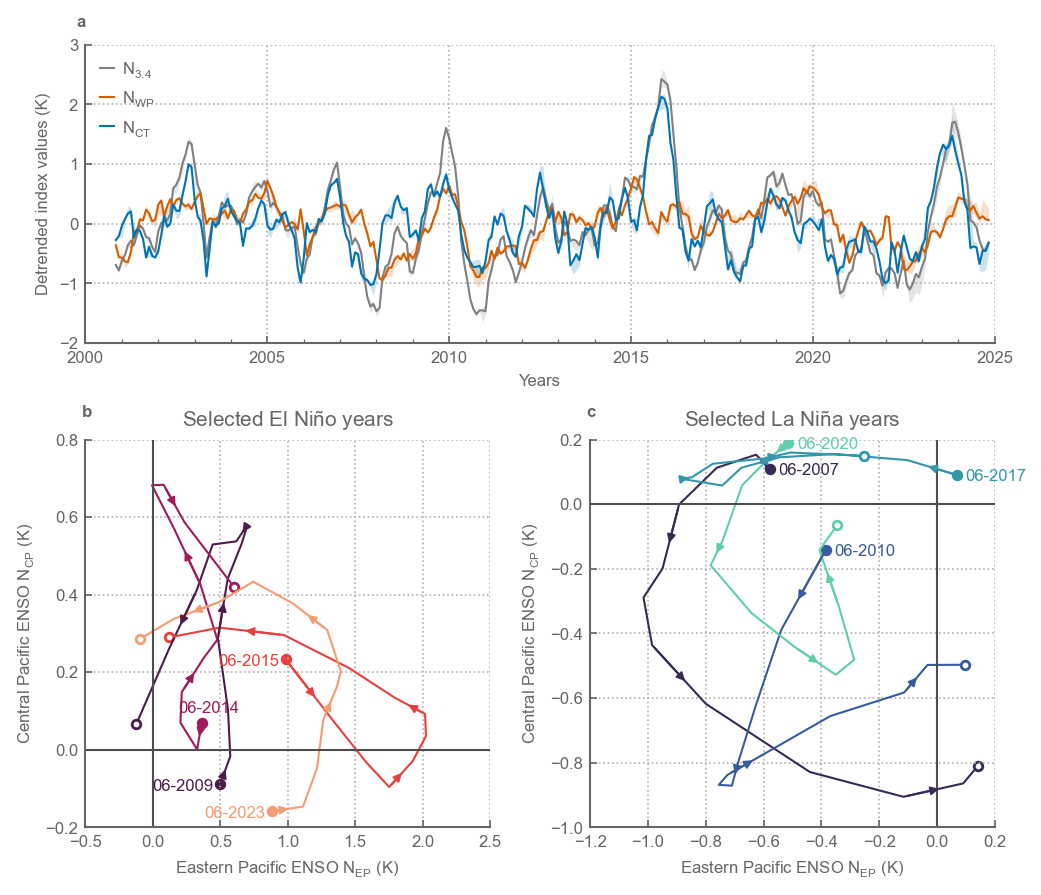

In [42]:
from matplotlib.dates import YearLocator

ninoyears = [2009,2014,2015,2023]
ninayears = [2007,2010,2017,2020]

fig, axs = plt.subplot_mosaic("""
                              CC
                              AB
                              """,
                              figsize = (7,6),
                              height_ratios=(1,1.3))


modes_notrend.lntime.plot(ax=axs['C'], hue='mode',color=['0.5','C3','C0'])
axs['C'].xaxis.set_major_locator(YearLocator(5))
axs['C'].xaxis.set_minor_locator(YearLocator(1))
axs['C'].set_xlim(pd.to_datetime(('2000','2025')))
axs['C'].set_ylim(-2,3)
axs['C'].set_title('')
axs['C'].set_xlabel('Years')
axs['C'].set_ylabel('Detrended index values (K)')

axs['C'].legend(["$N_{3.4}$","$N_{WP}$","$N_{CT}$"])




ninocolors = sns.color_palette('rocket', n_colors=len(ninoyears))
for k,year in enumerate(ninoyears):
    df_ = modes_notrend.rolling(time=3,center=True).mean().sel(time=slice(f"{year}-06",f"{year+1}-05")).mean('product').to_series().unstack().T
    df_.plot.line(x='EP',y='CP', ax=axs['A'], label=year, color=ninocolors[k], legend=False)
    df_.iloc[-1:].plot.scatter(x='EP',y='CP', ax=axs['A'], s=3, color='white', zorder=100)
    df_.iloc[::df_.index.size-1].plot.scatter(x='EP',y='CP', ax=axs['A'],  color=ninocolors[k])
    df_['dx']=df_.EP.diff().shift(-1)
    df_['dy']=df_.CP.diff().shift(-1)
    df_traj = df_.iloc[::3]
    for i in range(0, df_traj.index.size):
        axs['A'].annotate("", xytext=(df_traj.EP.iloc[i], df_traj.CP.iloc[i]), xy=(df_traj.EP.iloc[i] + df_traj.dx.iloc[i]/1.5, df_traj.CP.iloc[i]+ df_traj.dy.iloc[i]/1.5),
            arrowprops=dict(arrowstyle="-|>", color=ninocolors[k]),)
    if year==2014:
        axs['A'].text(df_.iloc[0].EP+.05,df_.iloc[0].CP+.02,f"06-{year}", va='bottom', ha='center',color=ninocolors[k], zorder=100)
    else:
        axs['A'].text(df_.iloc[0].EP-.05,df_.iloc[0].CP-.005,f"06-{year}", va='center', ha='right',color=ninocolors[k], zorder=100)
    # axs['C'].axvline(pd.to_datetime(f"06-{year}"), color=ninocolors[k])


ninacolors = sns.color_palette('mako', n_colors=len(ninayears))
for k,year in enumerate(ninayears):
    df_ = modes_notrend.rolling(time=3,center=True).mean().sel(time=slice(f"{year}-06",f"{year+1}-05")).mean('product').to_series().unstack().T
    axs['B'].plot(df_.EP, df_.CP, color=ninacolors[k], )
    df_.iloc[-1:].plot.scatter(x='EP',y='CP', ax=axs['B'], s=3, color='white', zorder=100)
    df_.iloc[::df_.index.size-1].plot.scatter(x='EP',y='CP', ax=axs['B'],  color=ninacolors[k], legend=False)
    df_['dx']=df_.EP.diff().shift(-1)
    df_['dy']=df_.CP.diff().shift(-1)
    df_traj = df_.iloc[::3]
    for i in range(0, df_traj.index.size):
        axs['B'].annotate("", xytext=(df_traj.EP.iloc[i], df_traj.CP.iloc[i]), xy=(df_traj.EP.iloc[i] + df_traj.dx.iloc[i]/1.5, df_traj.CP.iloc[i]+ df_traj.dy.iloc[i]/1.5),
            arrowprops=dict(arrowstyle="-|>", color=ninacolors[k]),)
    # axs['C'].axvline(pd.to_datetime(f"06-{year}"), color=ninacolors[k])
    axs['B'].text(df_.EP.iloc[0]+.03,df_.CP.iloc[0]-.005,f"06-{year}", va='center', color=ninacolors[k])
# axs['B'].get_legend().remove()
# axs['A'].legend().remove()

axs['A'].axhline(0, color='.3')
axs['A'].axvline(0, color='.3')
axs['B'].axhline(0, color='.3')
axs['B'].axvline(0, color='.3')
axs['A'].set(xlim=(-.5,2.5), ylim=(-.2,.8), xlabel='Eastern Pacific ENSO $N_{EP}$ (K)', ylabel='Central Pacific ENSO $N_{CP}$ (K)', title='Selected El $Ni\~no$ years')
axs['B'].set(xlim=(-1.2,.2), ylim=(-1,.2), xlabel='Eastern Pacific ENSO $N_{EP}$ (K)', ylabel='Central Pacific ENSO $N_{CP}$ (K)', title='Selected La $Ni\~na$ years')

axs['A'].text(-.01, 1.05, 'b', transform=axs['A'].transAxes, ha='left', va='bottom', weight='bold')
axs['B'].text(-.01, 1.05, 'c', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')
axs['C'].text(-.01, 1.05, 'a', transform=axs['C'].transAxes, ha='left', va='bottom', weight='bold')

plt.tight_layout()
plt.savefig('plots/BONUS_ENSO_cycles.pdf', dpi=300)


In [18]:
56/39

1.435897435897436

# Bonus figures not included in manuscript

## Figure bonus 1: example timeseries

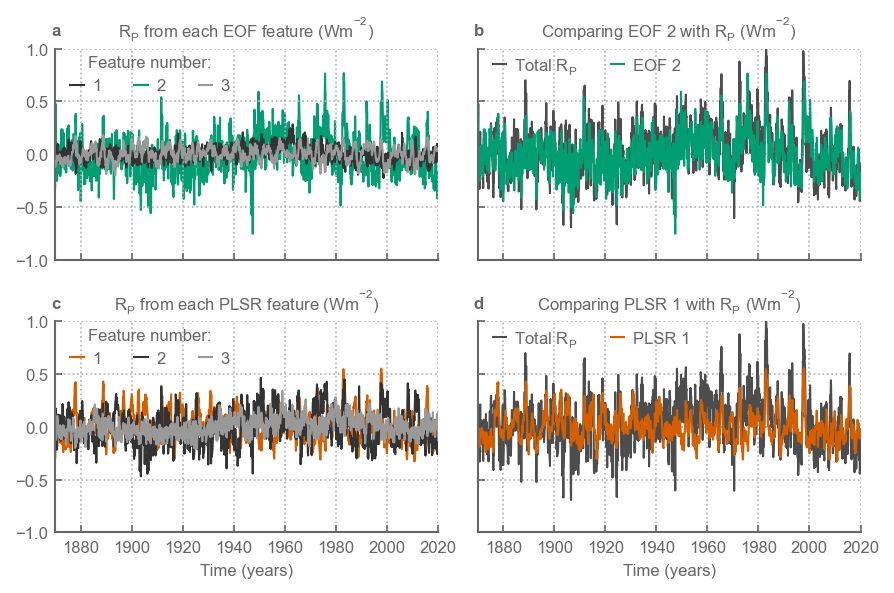

In [307]:
fig, axs = plt.subplots(2,2,figsize=(6,4), sharex=True, sharey=True)

eofs_one = eofs_pac.sel(GF_source='mean', product='HadISST')
plsr_one = plsr_pac.sel(GF_source='mean', product='HadISST')
Rp_one = Rp_pac.sel(GF_source='mean', product='HadISST')

eofs_one.pe.sel(feature=3).plot(ax=axs[0,0], color='.2', zorder=2, label='1')
eofs_one.pe.sel(feature=2).plot(ax=axs[0,0], color='C2', zorder=1, label='2')
eofs_one.pe.sel(feature=1).plot(ax=axs[0,0], color='.6', zorder=3, label='3')

plsr_one.pe.sel(feature=1).plot(ax=axs[1,0], color='C3', label='1')
plsr_one.pe.sel(feature=2).plot(ax=axs[1,0], color='.2', label='2')
plsr_one.pe.sel(feature=3).plot(ax=axs[1,0], color='.6', label='3')


Rp_one.plot(ax=axs[0,1], color='.3', label=r'Total $R_P$')
Rp_one.plot(ax=axs[1,1], color='.3', label=r'Total $R_P$')

eofs_one.dropna('time').pe.isel(feature=1).plot(ax=axs[0,1], color='C2', label='EOF 2')
plsr_one.pe.dropna('time').isel(feature=0).plot(ax=axs[1,1], color='C3', label='PLSR 1')

axs[0,0].legend(title='Feature number:', ncols=3, loc='upper left', bbox_to_anchor=(0,1.04))
axs[1,0].legend(title='Feature number:', ncols=3, loc='upper left', bbox_to_anchor=(0,1.04))
axs[0,1].legend( ncols=2, loc='upper left', bbox_to_anchor=(0,1.04))
axs[1,1].legend( ncols=2, loc='upper left', bbox_to_anchor=(0,1.04))

for k,ax in enumerate(axs.flatten()):
    ax.set(ylabel='',xlabel='', title='', xlim=pd.to_datetime(('1870','2020')), ylim=(-1,1))
    ax.text(-.01, 1.05, chr(ord('a')+k), transform=ax.transAxes, ha='left', va='bottom', weight='bold')


# axs['A'].set_ylabel(f"var($R_p$ EOF) / var($R_p$) (%)")
axs[1,0].set_xlabel(f"Time (years)")
axs[1,1].set_xlabel(f"Time (years)")
axs[0,0].set_title('$R_P$ from each EOF feature (Wm$^{-2}$)', size=8)
axs[0,1].set_title('Comparing EOF 2 with $R_P$ (Wm$^{-2}$)', size=8)
axs[1,0].set_title('$R_P$ from each PLSR feature (Wm$^{-2}$)', size=8)
axs[1,1].set_title('Comparing PLSR 1 with $R_P$ (Wm$^{-2}$)', size=8)



plt.tight_layout()
plt.savefig('plots/example_timeseries.pdf', dpi=300)

## Figure bonus 2: Lag-regression between ENSO indices

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


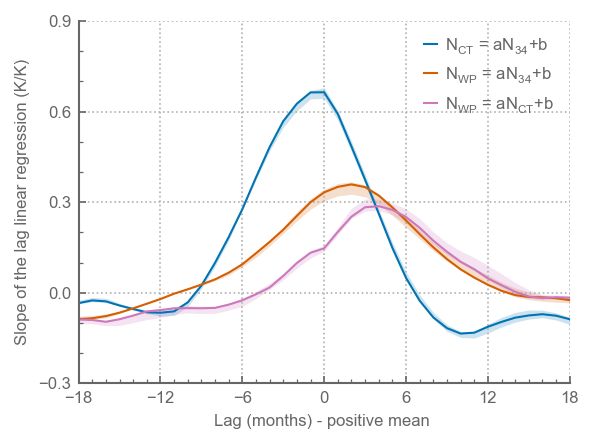

In [308]:
ds_nino_lag = xr.concat([xr_linregress(modes_notrend.sel(mode='nino34').shift(time=k), modes_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_ninocpep_lag = xr.concat([xr_linregress(modes_notrend.sel(mode='EP').shift(time=k), modes_notrend.sel(mode='CP')).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope

fig, ax = plt.subplots(figsize=(4,3))
ds_nino_lag.rename(lag='time').sel(mode='EP').lntime.plot(label='N$_{CT}$ = a$N_{34}$+b', color='C0')
ds_nino_lag.rename(lag='time').sel(mode='CP').lntime.plot(label='N$_{WP}$ = a$N_{34}$+b', color='C3')

ds_ninocpep_lag.rename(lag='time').lntime.plot(label='N$_{WP}$ = a$N_{CT}$+b', color='C4')
ax.set_title('')
ax.xaxis.set_major_locator(plt.MultipleLocator(6))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(.3))
ax.yaxis.set_minor_locator(plt.MultipleLocator(.1))
ax.set_ylabel('')
ax.set_title('')
ax.set_xlim((-18,18))
ax.set_ylim((-.3,.9))
ax.set_ylabel('Slope of the lag linear regression (K/K)')
ax.set_xlabel('Lag (months) - positive mean ')
plt.tight_layout()

plt.savefig('plots/lagregression_between_ENSO.pdf')